In [ ]:
import os
import s3fs
import zarr

from typing import Union

def s3_connection(path_to_zarr: os.path) -> s3fs.S3Map:
    """
    Instantiate connection to aws for a given path `path_to_zarr`
    """
    return s3fs.S3Map(
        root=path_to_zarr,
        s3=s3fs.S3FileSystem(anon=True),
        # anonymous access requires no credentials
        check=False,
    )


def load_single_aws_zarr(
    path_to_zarr: os.path,
    cache_max_single_size: int = None,
) -> Union[zarr.Array, zarr.Group]:
    """
    load zarr from s3 using LRU cache
    """
    return zarr.open(
        zarr.LRUStoreCache(
            store=s3_connection(path_to_zarr),
            max_size=cache_max_single_size,
        ),
        mode="r",
    )

In [ ]:
AWS_ZARR_ROOT = (
    "s3://gov-nasa-hdrl-data1/contrib/fdl-sdoml/fdl-sdoml-v2/sdomlv2_small.zarr/"
)

root = load_single_aws_zarr(
    path_to_zarr=AWS_ZARR_ROOT,
)

print(root.tree())

/
 ├── .zgroup () |S24
 └── 2010
     ├── 131A (6135, 512, 512) float32
     ├── 1600A (6136, 512, 512) float32
     ├── 1700A (6135, 512, 512) float32
     ├── 171A (6135, 512, 512) float32
     ├── 193A (6135, 512, 512) float32
     ├── 211A (6136, 512, 512) float32
     ├── 304A (6134, 512, 512) float32
     ├── 335A (6135, 512, 512) float32
     └── 94A (6136, 512, 512) float32


In [ ]:
AWS_ZARR_ROOT = (
    "s3://gov-nasa-hdrl-data1/contrib/fdl-sdoml/fdl-sdoml-v2/sdomlv2.zarr/"
)

root = load_single_aws_zarr(
    path_to_zarr=AWS_ZARR_ROOT,
)

print(root.tree())

/
 ├── 2010
 │   ├── 131A (47116, 512, 512) float32
 │   ├── 1600A (47972, 512, 512) float32
 │   ├── 1700A (46858, 512, 512) float32
 │   ├── 171A (47186, 512, 512) float32
 │   ├── 193A (47134, 512, 512) float32
 │   ├── 211A (47186, 512, 512) float32
 │   ├── 304A (47131, 512, 512) float32
 │   ├── 335A (47187, 512, 512) float32
 │   └── 94A (46930, 512, 512) float32
 ├── 2011
 │   ├── 131A (75200, 512, 512) float32
 │   ├── 1600A (75814, 512, 512) float32
 │   ├── 1700A (74839, 512, 512) float32
 │   ├── 171A (75660, 512, 512) float32
 │   ├── 193A (75664, 512, 512) float32
 │   ├── 211A (75678, 512, 512) float32
 │   ├── 304A (74199, 512, 512) float32
 │   ├── 335A (75624, 512, 512) float32
 │   └── 94A (75138, 512, 512) float32
 ├── 2012
 │   ├── 131A (76849, 512, 512) float32
 │   ├── 1600A (76630, 512, 512) float32
 │   ├── 1700A (69091, 512, 512) float32
 │   ├── 171A (76750, 512, 512) float32
 │   ├── 193A (76852, 512, 512) float32
 │   ├── 211A (76870, 512, 512) float32
 │  

In [ ]:
data = root["2010"]["131A"]

In [ ]:
data

<zarr.core.Array '/2010/131A' (47116, 512, 512) float32 read-only>

In [ ]:
import dask.array as da

In [ ]:
all_image = da.from_array(data)
all_image

dask.array<array, shape=(47116, 512, 512), dtype=float32, chunksize=(120, 512, 512), chunktype=numpy.ndarray>

In [ ]:
image = all_image[0, :, :]
image

dask.array<getitem, shape=(512, 512), dtype=float32, chunksize=(512, 512), chunktype=numpy.ndarray>

In [ ]:
import matplotlib.pyplot as plt

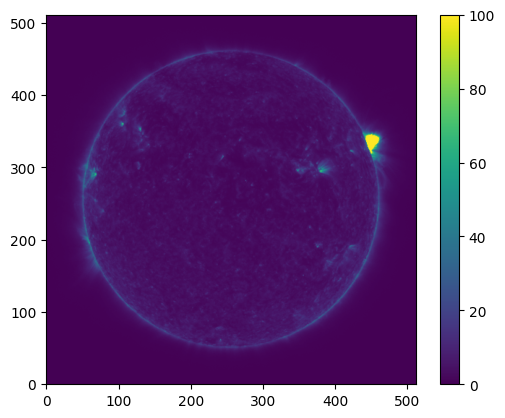

In [ ]:
plt.imshow(image, origin="lower", vmin=0, vmax=100)
plt.colorbar()
plt.show()

In [ ]:
data.attrs["T_OBS"][:5]

['2010-09-09T00:00:11.08Z',
 '2010-09-09T00:12:11.07Z',
 '2010-09-09T00:06:11.07Z',
 '2010-09-09T00:18:11.08Z',
 '2010-09-09T00:24:11.07Z']

In [ ]:
import numpy as np

In [ ]:
sorted_indices = np.argsort(data.attrs["T_OBS"])
sorted_indices

array([ 8937,  8939,  8938, ..., 13898, 13899, 13900], dtype=int64)

In [ ]:
len(sorted_indices)

47116

In [ ]:
np.array(data.attrs["T_OBS"])[sorted_indices][:5]

array(['2010-05-13T00:00:11.08Z', '2010-05-13T00:06:11.08Z',
       '2010-05-13T00:12:11.08Z', '2010-05-13T00:18:11.08Z',
       '2010-05-13T00:24:11.08Z'], dtype='<U23')

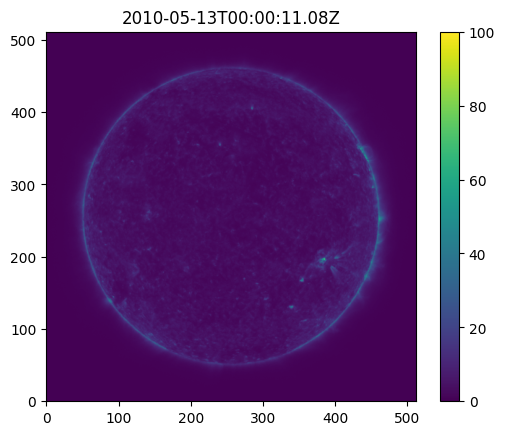

In [ ]:
all_image_sorted = da.from_array(data)[sorted_indices, :, :]
t_obs_sorted = np.array(data.attrs["T_OBS"])[sorted_indices]
plt.imshow(all_image_sorted[0], origin="lower", vmin=0, vmax=100)
plt.title(t_obs_sorted[0])
plt.colorbar()
plt.show()

In [ ]:
img_index = sorted_indices[0]
img_index

8937

In [ ]:
selected_image = da.from_array(data)[img_index, :, :]
selected_headr = {keys: values[img_index] for keys, values in data.attrs.items()}

In [ ]:
import sunpy.map

In [ ]:
my_map = sunpy.map.Map((np.array(selected_image), selected_headr))

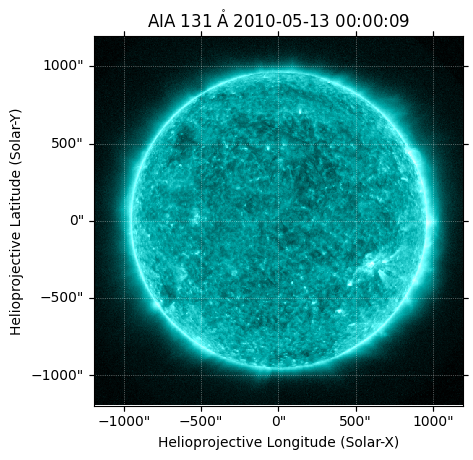

In [ ]:
plt.figure()
ax = plt.subplot(projection=my_map)
my_map.plot();

In [ ]:
root = load_single_aws_zarr(
    path_to_zarr="s3://gov-nasa-hdrl-data1/contrib/fdl-sdoml/fdl-sdoml-v2/sdomlv2_hmi_small.zarr/",
)

print(root.tree())

/
 └── 2010
     ├── Bx (25540, 512, 512) float32
     ├── By (25540, 512, 512) float32
     └── Bz (25540, 512, 512) float32


In [ ]:
root = load_single_aws_zarr(
    path_to_zarr="s3://gov-nasa-hdrl-data1/contrib/fdl-sdoml/fdl-sdoml-v2/sdomlv2_hmi.zarr",
)

print(root.tree())

/
 ├── 2010
 │   ├── Bx (25540, 512, 512) float32
 │   ├── By (25540, 512, 512) float32
 │   └── Bz (25540, 512, 512) float32
 ├── 2011
 │   ├── Bx (40086, 512, 512) float32
 │   ├── By (40086, 512, 512) float32
 │   └── Bz (40086, 512, 512) float32
 ├── 2012
 │   ├── Bx (40172, 512, 512) float32
 │   ├── By (40172, 512, 512) float32
 │   └── Bz (40172, 512, 512) float32
 ├── 2013
 │   ├── Bx (38540, 512, 512) float32
 │   ├── By (38540, 512, 512) float32
 │   └── Bz (38540, 512, 512) float32
 ├── 2014
 │   ├── Bx (40590, 512, 512) float32
 │   ├── By (40590, 512, 512) float32
 │   └── Bz (40590, 512, 512) float32
 ├── 2015
 │   ├── Bx (40490, 512, 512) float32
 │   ├── By (40490, 512, 512) float32
 │   └── Bz (40490, 512, 512) float32
 ├── 2016
 │   ├── Bx (40452, 512, 512) float32
 │   ├── By (40452, 512, 512) float32
 │   └── Bz (40452, 512, 512) float32
 ├── 2017
 │   ├── Bx (40976, 512, 512) float32
 │   ├── By (40976, 512, 512) float32
 │   └── Bz (40976, 512, 512) float32
 ├── 2

In [ ]:
data = root["2010"]["Bz"]
data

<zarr.core.Array '/2010/Bz' (25540, 512, 512) float32 read-only>

In [ ]:
data.attrs["T_OBS"][:5]

['2010.05.01_00:12:04_TAI',
 '2010.05.01_00:24:04_TAI',
 '2010.05.01_00:36:04_TAI',
 '2010.05.01_00:48:04_TAI',
 '2010.05.01_01:00:04_TAI']

In [ ]:
sorted_indices = np.argsort(data.attrs["T_OBS"])
sorted_indices

array([    0,     1,     2, ..., 25537, 25538, 25539], dtype=int64)

In [ ]:
img_index = sorted_indices[0]
img_index

0

In [ ]:
selected_image = da.from_array(data)[img_index, :, :]
selected_image

dask.array<getitem, shape=(512, 512), dtype=float32, chunksize=(512, 512), chunktype=numpy.ndarray>

<matplotlib.image.AxesImage>

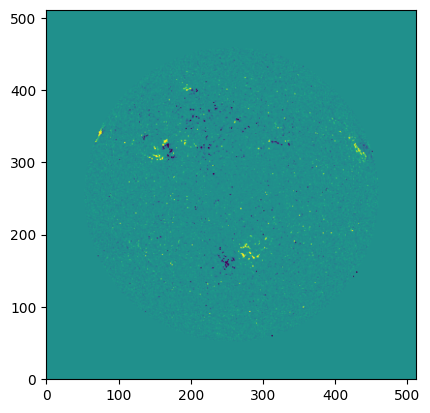

In [ ]:
plt.imshow(selected_image, origin="lower", vmin=-100, vmax=100)

In [ ]:
selected_headr = {keys: values[img_index] for keys, values in data.attrs.items()}

In [ ]:
my_map = sunpy.map.Map((np.array(selected_image), selected_headr))

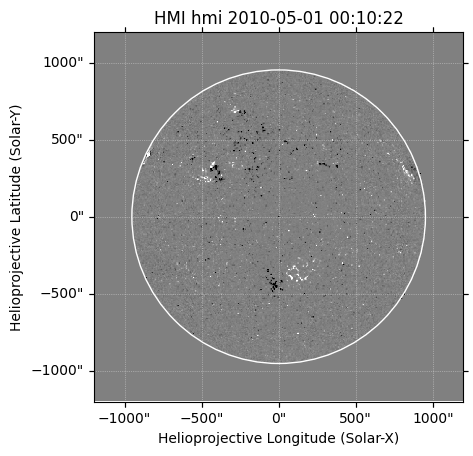

In [ ]:
plt.figure()
ax = plt.subplot(projection=my_map)
my_map.plot(vmin=-100, vmax=100)
my_map.draw_limb();

In [ ]:
root = load_single_aws_zarr(
    path_to_zarr="s3://gov-nasa-hdrl-data1/contrib/fdl-sdoml/fdl-sdoml-v2/sdomlv2_eve.zarr/",
)

print(root.tree())

/
 └── MEGS-A
     ├── C III (2137380,) float32
     ├── Fe IX (2137380,) float32
     ├── Fe VIII (2137380,) float32
     ├── Fe X (2137380,) float32
     ├── Fe XI (2137380,) float32
     ├── Fe XII (2137380,) float32
     ├── Fe XIII (2137380,) float32
     ├── Fe XIV (2137380,) float32
     ├── Fe XIX (2137380,) float32
     ├── Fe XV (2137380,) float32
     ├── Fe XVI (2137380,) float32
     ├── Fe XVIII (2137380,) float32
     ├── Fe XVI_2 (2137380,) float32
     ├── Fe XX (2137380,) float32
     ├── Fe XX_2 (2137380,) float32
     ├── Fe XX_3 (2137380,) float32
     ├── H I (2137380,) float32
     ├── H I_2 (2137380,) float32
     ├── H I_3 (2137380,) float32
     ├── He I (2137380,) float32
     ├── He II (2137380,) float32
     ├── He II_2 (2137380,) float32
     ├── He I_2 (2137380,) float32
     ├── Mg IX (2137380,) float32
     ├── Mg X (2137380,) float32
     ├── Mg X_2 (2137380,) float32
     ├── Ne VII (2137380,) float32
     ├── Ne VIII (2137380,) float32
     ├── O II 

In [ ]:
data = root["MEGS-A"]["Fe XX"]
data

<zarr.core.Array '/MEGS-A/Fe XX' (2137380,) float32 read-only>

In [ ]:
times = root["MEGS-A"]["Time"]
times[:5]

array(['2010-05-01 00:00:10.484', '2010-05-01 00:01:10.484',
       '2010-05-01 00:02:10.484', '2010-05-01 00:03:10.484',
       '2010-05-01 00:04:10.484'], dtype='<U23')

In [ ]:
import pandas as pd 

In [ ]:
df = pd.Series(data, index=pd.to_datetime(times))
df

2010-05-01 00:00:10.484    7.858343e-07
2010-05-01 00:01:10.484    8.028433e-07
2010-05-01 00:02:10.484    7.927638e-07
2010-05-01 00:03:10.484    7.809158e-07
2010-05-01 00:04:10.484    7.822941e-07
                               ...     
2014-05-26 23:55:09.854   -1.000000e+00
2014-05-26 23:56:09.854   -1.000000e+00
2014-05-26 23:57:09.854   -1.000000e+00
2014-05-26 23:58:09.854   -1.000000e+00
2014-05-26 23:59:09.855   -1.000000e+00
Length: 2137380, dtype: float32

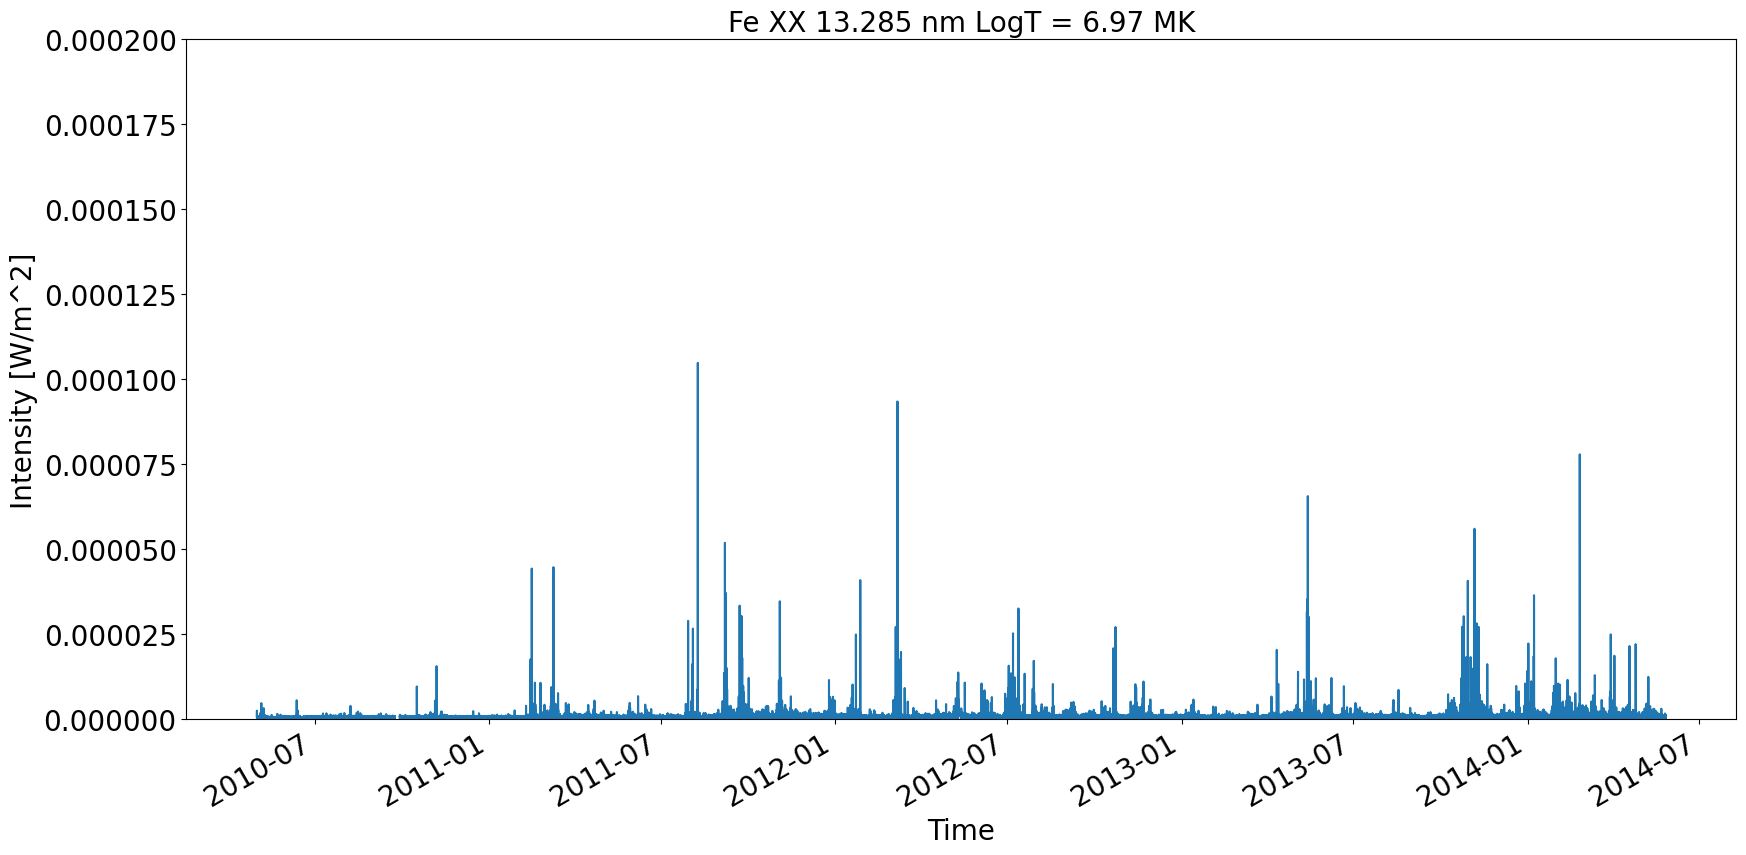

In [ ]:
ax = df.plot(ylim=(0,2.e-4), figsize=(20,10), fontsize=20)
ax.set_title(str(data.attrs['ion'])+' '+str(data.attrs['wavelength'])+' LogT = '+str(data.attrs['logT']), fontsize=20)
ax.set_xlabel("Time", fontsize=20)
ax.set_ylabel("Intensity [W/m^2]", fontsize=20);